In [1]:
import pickle
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EmpiricalCovariance
import torch
#from ..ood_distance import *
#from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE

In [1]:
!ls

bear_road.jpg			      feature_viz_with_gt_coco.ipynb
deer_road.jpeg			      montreal-construction.jpeg
elephant_road.jpg		      ood-distance.ipynb
embed_viz.ipynb			      slurm-4712379.out
feature_finetune-coco_viz.ipynb       slurm-4714658.out
feature_viz_finetune-bigdet.ipynb     snow_road.jpeg
feature_viz_finetune_coco.ipynb       Topic-Pic-Bad-Weather.jpg
feature_viz.ipynb		      yak_road.jpeg
feature_viz_with_big_detection.ipynb


In [ ]:
with open('classwise_GTfeatures.pkl', 'rb') as f:
        embed_classwise = pickle.load(f)

In [2]:
embed_classwise = {}
fea_path = "/home/vaibhav/Desktop/stud/datasets/esmart/bigdetect_features/GT/pooled/"

In [3]:
for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1

In [13]:
a = np.array(embed_classwise[5])

In [14]:
a.shape

(165, 1024)

In [19]:
embed_classwise[0][0].shape

(1024,)

In [49]:
classwise_mean = np.zeros((len(embed_classwise.keys()),embed_classwise[0][0].shape[0]),dtype='float32')
precision = []
for c in range(len(embed_classwise.keys())):
    f_x = np.array(embed_classwise[c])
    classwise_mean[c] = f_x.mean(axis=0)
    f_x = f_x - classwise_mean[c][np.newaxis,:]
    print(f_x.shape)
    precision.append(f_x)

(170, 1024)
(392, 1024)
(42233, 1024)
(625, 1024)
(7420, 1024)
(165, 1024)
(1573, 1024)
(7762, 1024)
(6797, 1024)
(1032, 1024)
(4381, 1024)
(4470, 1024)


In [50]:
precision = np.concatenate(precision,axis=0)

In [51]:
precision.shape

(77020, 1024)

In [28]:
classwise_mean[0]

array([0.00576049, 0.12466978, 0.45142594, ..., 0.0345595 , 0.42663744,
       1.5739923 ], dtype=float32)

In [45]:
a = np.array(embed_classwise[0]) - classwise_mean[0][np.newaxis,:]

In [47]:
a.shape

(170, 1024)

In [58]:
group_lasso = EmpiricalCovariance(assume_centered=False)
final_precision = []
group_lasso.fit(precision)
temp_precision = group_lasso.precision_
#temp_precision = torch.from_numpy(temp_precision).float().cuda()
final_precision.append(temp_precision)

In [60]:
final_precision[0].shape

(1024, 1024)

In [62]:
temp_precision.shape

(1024, 1024)

In [65]:
def sample_estimator(embed_classwise):
    classwise_mean = np.zeros((len(embed_classwise.keys()),embed_classwise[0][0].shape[0]),dtype='float32')
    precision = []
    X = None
    group_lasso = EmpiricalCovariance(assume_centered=False)
    for c in range(len(embed_classwise.keys())):
        f_x = np.array(embed_classwise[c])
        classwise_mean[c] = f_x.mean(axis=0)
        f_x = f_x - classwise_mean[c][np.newaxis,:]
        if c == embed_classwise.keys[0]:
             X = f_x
        else:
            X.concatenate(f_x,axis=0)
        ### finding inverse of covariance
    group_lasso.fit(f_x)
    precision = group_lasso.precision_
    #precision = np.array(precision)
   

    return classwise_mean,precision
#torch.from_numpy(classwise_mean).float().to(device),torch.from_numpy(precision).float().to(device)


In [66]:
sample_mean,cov = sample_estimator(embed_classwise)

In [67]:
sample_mean.shape

(12, 1024)

In [68]:
cov.shape

(12, 1024, 1024)

In [17]:
from detectron2.config import get_cfg
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.structures import Boxes
from detectron2.checkpoint import DetectionCheckpointer

In [28]:
import detectron2.data.transforms as T

In [3]:
#register dataset
def register_esmart_wip(root = "/home/mila/v/vaibhav.jade/scratch/intern/stud/datasets/esmart/"):
        things_classes = ["bicycle","bus","car","lane","lanes","motorcycle","person",
                        "roadwork_tcd","speed_limit","stop sign", "traffic light",
                        "truck"]
        name = 'esmart_wip'
        metadata = {"thing_classes":things_classes}
        register_coco_instances(
                        name,
                        metadata,
                        os.path.join(root, 'labels.json'),
                        os.path.join(root, 'data/'),
                    )

register_esmart_wip()

In [45]:

cfg = get_cfg()
#cfg.merge_from_file("/home/vaibhav/Desktop/stud/configs/BDD100k/stud_resnet.yaml")
#cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=False)  # Use the appropriate config file
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_coco_trained.yaml")
#cfg._BASE_ = "/home/mila/v/vaibhav.jade/scratch/intern/stud/configs/Base-RCNN-FPN.yaml"
cfg.DATASETS.TEST = ("esmart_wip",)

cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/coco_finetune_on_esmart/model_final.pth"
test_data_loader = build_detection_test_loader(cfg,"esmart_wip")

model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/finetune_coco_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



{'trainer': {'iteration': 9000,
  'hooks': {'LRScheduler': {'base_lrs': [0.02], 'last_epoch': 9001}}},
 'iteration': 9000}

In [82]:
cfg = get_cfg()
#cfg.merge_from_file("/home/vaibhav/Desktop/stud/configs/BDD100k/stud_resnet.yaml")
#cfg = model_zoo.get_config(config_path="COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",trained=False)  # Use the appropriate config file
cfg.merge_from_file("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/coco_trained.yaml")
#cfg._BASE_ = "/home/mila/v/vaibhav.jade/scratch/intern/stud/configs/Base-RCNN-FPN.yaml"
cfg.DATASETS.TEST = ("esmart_wip",)

cfg.MODEL.WEIGHTS = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/model_final_b275ba.pkl"
test_data_loader = build_detection_test_loader(cfg,"esmart_wip")

coco_model = build_model(cfg)
checkpointer = DetectionCheckpointer(coco_model)
checkpointer.load(cfg.MODEL.WEIGHTS)

Config '/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/configs/coco_trained.yaml' has no VERSION. Assuming it to be compatible with latest v2.

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



{'__author__': 'Detectron2 Model Zoo'}

In [21]:
embed_classwise = {}
fea_path = "/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/checkpoints/esmart/coco_features/gt/box"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for im in os.listdir(fea_path):
    x = {}
    with open(os.path.join(fea_path,im), 'rb') as f:
        x = pickle.load(f)
        
    idx = 0
    for i in x['preds']:
        if embed_classwise.get(i.item()) == None:
            embed_classwise[i.item()] = [x['features'][idx].detach().cpu().numpy()]
        else:
            embed_classwise[i.item()].append(x['features'][idx].detach().cpu().numpy())
        idx += 1

def sample_estimator(embed_classwise,num_classes):
    classwise_mean = np.zeros((num_classes,embed_classwise[0][0].shape[0]),dtype='float32')
    precision = []
    X = None
    group_lasso = EmpiricalCovariance(assume_centered=False)
    for c in embed_classwise.keys():
        f_x = np.array(embed_classwise[c])
        classwise_mean[c] = f_x.mean(axis=0)
        f_x = f_x - classwise_mean[c][np.newaxis,:]
        if c == list(embed_classwise.keys())[0]:
             X = f_x
        else:
            np.concatenate((X,f_x),axis=0)
        ### finding inverse of covariance
    group_lasso.fit(X)
    precision = group_lasso.precision_
    #precision = np.array(precision)
   

    return torch.from_numpy(classwise_mean).float().to(device),torch.from_numpy(precision).float().to(device)



In [22]:
sample_mean,precision = sample_estimator(embed_classwise,12)

In [34]:
def get_features_for_proposals(model, input, instances = None):
    def hook1(module, input, output):
            proposals.append(output)

    def hook2(module, input, output):
            features.append(output)
    
    ### hooks to get feature maps from backbone 
    h1 = model.proposal_generator.register_forward_hook(hook1)
    h2 = model.roi_heads.box_head.register_forward_hook(hook2)
    features = []
    proposals =[]
    predictions = model([input])[0]
    h1.remove()
    h2.remove()

    return proposals[0],features[0]

In [23]:
def get_features(model, input, instances = None):
    
    def hook(module, input, output):
                features.append(output)
    
    ### hooks to get feature maps from backbone 
    h = model.backbone.register_forward_hook(hook)
    features = []
    predictions = model([input])[0]
    h.remove()

    # Get detection instances
    if instances == None:
        instances = predictions['instances']

    # Get detected boxes and extract corresponding feature embeddings
    ### detaching predictions from computation graph
    pred_boxes = Boxes(instances.proposal_boxes.tensor.detach())  # Prediction boxes (x1, y1, x2, y2)
    roi_pooler = model.roi_heads.box_pooler  # ROI feature extractor
    feature_extractor = model.roi_heads.box_head

    pooled_features = roi_pooler([features[0][f] for f in model.roi_heads.in_features], [pred_boxes])
    roi_features = feature_extractor(pooled_features)

    return instances, roi_features


def get_features_for_proposals(model, input, instances = None):
    def hook1(module, input, output):
            proposals.append(output)

    def hook2(module, input, output):
            features.append(output)
    
    ### hooks to get feature maps from backbone 
    h1 = model.proposal_generator.register_forward_hook(hook1)
    h2 = model.roi_heads.box_head.register_forward_hook(hook2)
    #h3 = model.roi_heads.box_predictor.register_forward_hook(hook2)
    features = []
    proposals =[]
    predictions = model([input])
    h1.remove()
    h2.remove()
    #h3.remove()

    return proposals[0][0][0],features[0],predictions

def eval_ood_on_data(model,test_loader,num_classes, sample_mean, precision,magnitude):
     ### a FasterRCNN model (we are not using trainer or predictor of detectron2)
    model.eval()
    model.requires_grad_(False)
    copy_model = copy.deepcopy(model)
    copy_model.eval()
    copy_model.requires_grad_(False)
    sample_mean.requires_grad_(False)
    precision.requires_grad_(False)

    Mahalanobis_score = []
    image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/snow_road.jpeg")
    height, width = image.shape[:2]
    aug = T.ResizeShortestEdge(
        [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
        )
    image = aug.get_transform(image).apply_image(image)
    image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
    image.to(device)

    inputs = {"image": image, "height": height, "width": width}
    score = get_Mahalanobis_score(model,copy_model,inputs,num_classes, sample_mean, precision,magnitude)
    # for batch in test_loader:
    #     for sample in batch:
    #         score = get_Mahalanobis_score(model,copy_model,sample,num_classes, sample_mean, precision,magnitude)
    #         Mahalanobis_score.append(score)

def get_Mahalanobis_score(model, copy_model, input, num_classes, sample_mean, precision,magnitude):
    '''
    Compute the proposed Mahalanobis confidence score on input dataset
    return: Mahalanobis score from layer_index
    '''
    
    Mahalanobis = []
    
    inp_image,h,w = input['image'],input['height'],input['width']
    ### the backward graph settings             
    inp_image = inp_image.to(device=device).to(dtype=torch.float32).requires_grad_(True)   

    im = {"image": inp_image, "height": h, "width": w}
    ### forward pass and roi pooling features
    ### Warning! instances here is still connected to graph,
    ### pass it under no_grad() context or be careful    
    instances,out_features = get_features_for_proposals(model,im)
 
    # compute Mahalanobis score
    gaussian_score = 0
    out_features = torch.unsqueeze(out_features,1)
    sample_mean = torch.unsqueeze(sample_mean,0)
    zero_f = out_features - sample_mean     #shape b,n_c,1024
    ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
    gaussian_score = torch.matmul(torch.matmul(zero_f,precision), torch.transpose(zero_f,1,2))
    ### taking diag() of (n_c,n_c) matrices
    gaussian_score = gaussian_score*torch.eye(num_classes,num_classes,device=device)
    gaussian_score = -0.5*gaussian_score.sum(dim=-1)
    
    ### there's no need to calculate again as its the same calculation
    loss = -gaussian_score.max(dim=1)[0]
    
    for l in range(len(loss)):
        if l == len(loss) - 1:
            model.zero_grad()
            inp_image.grad = None
            loss[l].backward()
        else:
            model.zero_grad()
            inp_image.grad = None
            loss[l].backward(retain_graph=True)
        ### sign function on gradients
        gradient =  torch.ge(inp_image.grad, 0)
        gradient = (gradient.float() - 0.5) * 2
    
        ### scaling the gradient by image preprocessing std in original code, 
        ### not needed as its 1 in FasterRCNN, subject to specific case

        # gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (model.pixel_std[0]))
        # gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (model.pixel_std[1]))
        # gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (model.pixel_std[2]))
    
        tempInputs = torch.add(inp_image, -magnitude, gradient)

        with torch.no_grad():
            
            _,noise_out_features = get_features(copy_model,{"image": tempInputs, "height": h, "width": w},instances)

            noise_gaussian_score = 0
            noise_out_features = torch.unsqueeze(noise_out_features[l],0)
            noise_zero_f = noise_out_features - sample_mean.squeeze()     #shape b,n_c,1024
            ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
            noise_gaussian_score = -0.5*torch.mm(torch.mm(noise_zero_f,precision), noise_zero_f.t()).diag()
            
            noise_gaussian_score = torch.max(noise_gaussian_score)
            Mahalanobis.append(noise_gaussian_score.cpu().numpy())
        
    return [[instances.pred_boxes.tensor.detach().cpu().numpy(),instances.pred_classes.detach().cpu().numpy()],Mahalanobis]


In [5]:
import copy
import cv2

In [46]:
model.eval()
model.requires_grad_(False)
copy_model = copy.deepcopy(model)
copy_model.eval()
copy_model.requires_grad_(False)
#sample_mean.requires_grad_(False)
#precision.requires_grad_(False)

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

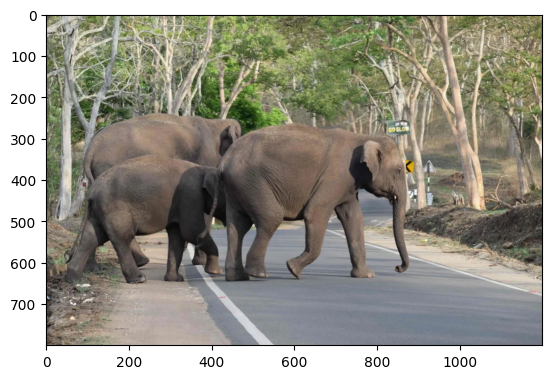

In [9]:
image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/elephant_road.jpg")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [30]:
image.shape[:2]

(183, 275)

In [31]:
 height, width = image.shape[:2]
input = {"image": image, "height": height, "width": width}

In [120]:
image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/elephant_road.jpg")
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
image = aug.get_transform(image).apply_image(image)
image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
image.to(device)

inputs = {"image": image, "height": height, "width": width}
Mahalanobis = []
    
inp_image,h,w = inputs['image'],inputs['height'],inputs['width']
### the backward graph settings             
inp_image = inp_image.to(device=device).to(dtype=torch.float32).requires_grad_(True)   

im = {"image": inp_image, "height": h, "width": w}
### forward pass and roi pooling features
### Warning! instances here is still connected to graph,
### pass it under no_grad() context or be careful    
instances,out_features,predictions = get_features_for_proposals(model,im)

# compute Mahalanobis score
gaussian_score = 0
out_features = torch.unsqueeze(out_features,1)
sample_mean = torch.unsqueeze(sample_mean,0)
zero_f = out_features - sample_mean     #shape b,n_c,1024
### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
gaussian_score = torch.matmul(torch.matmul(zero_f,precision), torch.transpose(zero_f,1,2))
### taking diag() of (n_c,n_c) matrices
gaussian_score = gaussian_score*torch.eye(num_classes,num_classes,device=device)
gaussian_score = -0.5*gaussian_score.sum(dim=-1)

### there's no need to calculate again as its the same calculation
loss = -gaussian_score.max(dim=1)[0]

for l in range(len(loss)):
    if l == len(loss) - 1:
        model.zero_grad()
        inp_image.grad = None
        loss[l].backward()
    else:
        model.zero_grad()
        inp_image.grad = None
        loss[l].backward(retain_graph=True)
    ### sign function on gradients
    gradient =  torch.ge(inp_image.grad, 0)
    gradient = (gradient.float() - 0.5) * 2

    ### scaling the gradient by image preprocessing std in original code, 
    ### not needed as its 1 in FasterRCNN, subject to specific case

    # gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (model.pixel_std[0]))
    # gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (model.pixel_std[1]))
    # gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (model.pixel_std[2]))

    tempInputs = torch.add(inp_image, -magnitude, gradient)

    with torch.no_grad():

        _,noise_out_features = get_features(copy_model,{"image": tempInputs, "height": h, "width": w},instances)

        noise_gaussian_score = 0
        noise_out_features = torch.unsqueeze(noise_out_features[l],0)
        noise_zero_f = noise_out_features - sample_mean.squeeze()     #shape b,n_c,1024
        ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
        noise_gaussian_score = -0.5*torch.mm(torch.mm(noise_zero_f,precision), noise_zero_f.t()).diag()

        noise_gaussian_score = torch.max(noise_gaussian_score)
        Mahalanobis.append(noise_gaussian_score.cpu().numpy())

RuntimeError: batch1 dim 2 must match batch2 dim 1

In [47]:
image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/elephant_road.jpg")
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
im = aug.get_transform(image).apply_image(image)
im = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
im.to(device)

inputs = {"image": im, "height": height, "width": width}
instances,out_features,predictions = get_features_for_proposals(model,inputs)

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [108]:
coco_model.eval()
image = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/deer_road.jpeg")
height, width = image.shape[:2]
num_classes = 12
magnitude = 0.01
aug = T.ResizeShortestEdge(
    [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
    )
im = aug.get_transform(image).apply_image(image)
im = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
im.to(device)

inputs = {"image": im, "height": height, "width": width}
coco_preds = coco_model([inputs])[0]

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [48]:
instances

Instances(num_instances=100, image_height=800, image_width=1200, fields=[proposal_boxes: Boxes(tensor([[ 399.2410,  270.4949,  900.1802,  637.6940],
        [  14.4517,  288.4372,  505.4096,  671.3233],
        [ 362.3553,  261.7224,  766.8749,  648.4877],
        [  63.8774,  216.7126,  501.8896,  627.8691],
        [  99.8442,  248.3656,  468.3048,  391.7164],
        [ 139.8256,  277.9023,  557.0288,  669.9119],
        [  20.2720,  191.2536,  451.9694,  714.4336],
        [ 427.8658,  200.6723,  894.2094,  713.5110],
        [  67.3700,  283.6666,  671.6171,  655.1855],
        [ 205.5967,  354.1612,  465.0385,  628.1588],
        [   0.0000,  189.2011,  699.7777,  628.3431],
        [  89.7014,  337.8115,  454.6005,  641.7399],
        [ 160.5684,  275.7224,  776.0099,  648.3822],
        [ 507.7680,  235.4538,  911.8659,  678.1602],
        [ 979.9811,  425.8990, 1014.1181,  463.5679],
        [ 265.4258,  237.2781,  875.2028,  635.5523],
        [ 257.2900,  327.1978,  444.1861,

In [53]:
from detectron2.layers import batched_nms

In [73]:
out_nms = batched_nms(instances.proposal_boxes.tensor,instances.objectness_logits,torch.ones_like(instances.objectness_logits),0.5)

In [77]:
len(out_nms)

29

In [57]:
instances.proposal_boxes.tensor

tensor([[ 399.2410,  270.4949,  900.1802,  637.6940],
        [  14.4517,  288.4372,  505.4096,  671.3233],
        [ 362.3553,  261.7224,  766.8749,  648.4877],
        [  63.8774,  216.7126,  501.8896,  627.8691],
        [  99.8442,  248.3656,  468.3048,  391.7164],
        [ 139.8256,  277.9023,  557.0288,  669.9119],
        [  20.2720,  191.2536,  451.9694,  714.4336],
        [ 427.8658,  200.6723,  894.2094,  713.5110],
        [  67.3700,  283.6666,  671.6171,  655.1855],
        [ 205.5967,  354.1612,  465.0385,  628.1588],
        [   0.0000,  189.2011,  699.7777,  628.3431],
        [  89.7014,  337.8115,  454.6005,  641.7399],
        [ 160.5684,  275.7224,  776.0099,  648.3822],
        [ 507.7680,  235.4538,  911.8659,  678.1602],
        [ 979.9811,  425.8990, 1014.1181,  463.5679],
        [ 265.4258,  237.2781,  875.2028,  635.5523],
        [ 257.2900,  327.1978,  444.1861,  651.7323],
        [ 214.9861,  246.8382,  668.4553,  671.6388],
        [  41.9919,  369.235

In [79]:
prop_boxes = instances.proposal_boxes.tensor[out_nms[:min(20,len(out_nms))]]

In [89]:
from torchvision.ops import box_iou

ImportError: cannot import name 'complete_box_iou' from 'torchvision.ops' (/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/torchvision/ops/__init__.py)

In [90]:
iou_scores = box_iou(prop_boxes,coco_preds['instances'].pred_boxes.tensor)

In [91]:
iou_scores

tensor([[0.9615, 0.0476, 0.0412, 0.0000],
        [0.1092, 0.6320, 0.2428, 0.0000],
        [0.0346, 0.1164, 0.7744, 0.0000],
        [0.0718, 0.5294, 0.1373, 0.0000],
        [0.5006, 0.3376, 0.1727, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8761],
        [0.0000, 0.0000, 0.0000, 0.4918],
        [0.0856, 0.3578, 0.4747, 0.0000],
        [0.0228, 0.5809, 0.0000, 0.0000],
        [0.0000, 0.5338, 0.1793, 0.0000],
        [0.1614, 0.3158, 0.3328, 0.0000],
        [0.0077, 0.0000, 0.0000, 0.0000],
        [0.1805, 0.4337, 0.0143, 0.0000],
        [0.0035, 0.0000, 0.0000, 0.0000],
        [0.1554, 0.2856, 0.1340, 0.0000],
        [0.0206, 0.0033, 0.0621, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.1807, 0.1461, 0.0000, 0.0000],
        [0.3623, 0.1637, 0.0542, 0.0000],
        [0.1633, 0.3479, 0.2335, 0.0000]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [49]:
predictions

[{'instances': Instances(num_instances=0, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}]

In [25]:
from detectron2.utils.visualizer import Visualizer 

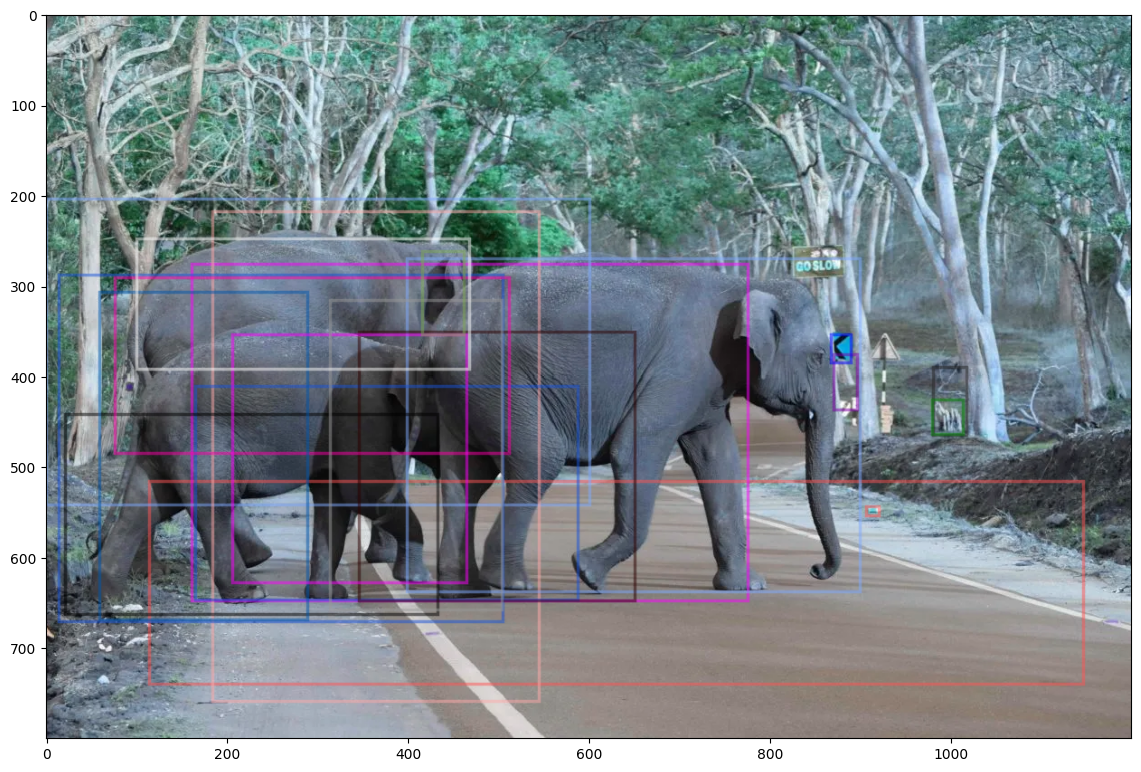

In [76]:
v_pred = Visualizer(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), None)
v_pred = v_pred.overlay_instances(
    boxes=instances.proposal_boxes.tensor[out_nms[:20]].cpu()
    #labels = ["ood" for i in range(31)]
)
plt.figure(figsize = (14, 10))
plt.imshow(v_pred.get_image()[:, :, ::-1])

In [112]:
v_f = Visualizer(image, None)
v_f = v_f.overlay_instances(
    boxes=coco_preds['instances'].pred_boxes.tensor.detach().cpu().numpy(),
    labels = ["ood" for i in range(len(coco_preds['instances'].pred_classes))]
)

In [113]:
coco_preds['instances'].pred_classes

tensor([17, 19, 17], device='cuda:0')

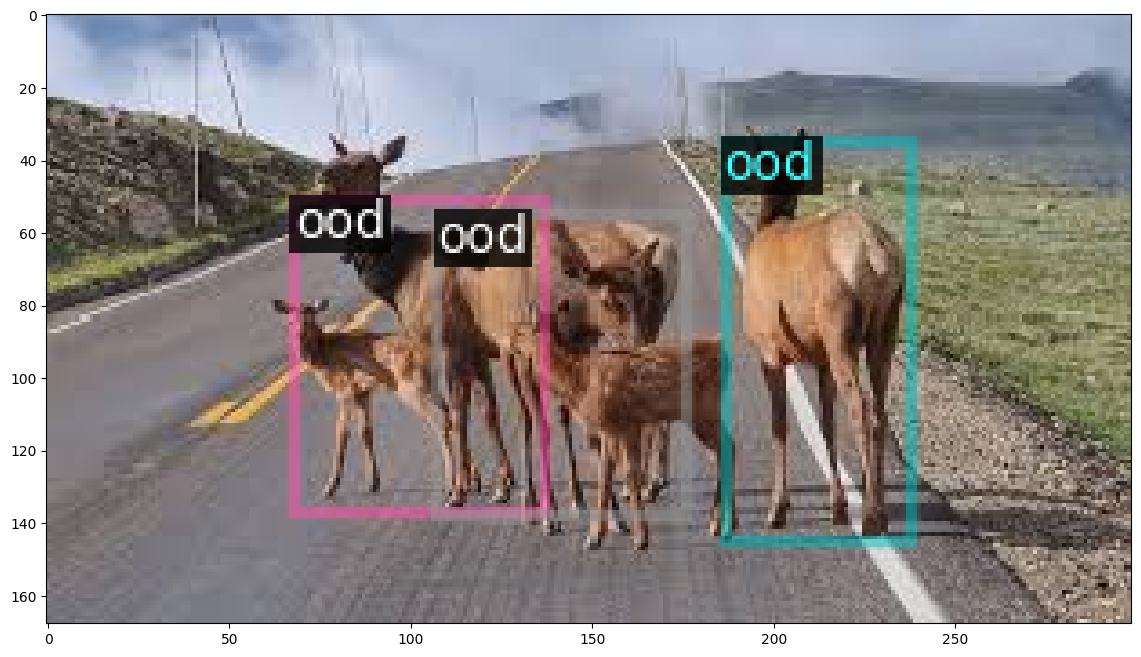

In [114]:
plt.figure(figsize = (14, 10))
plt.imshow(v_f.get_image()[:, :, ::-1])

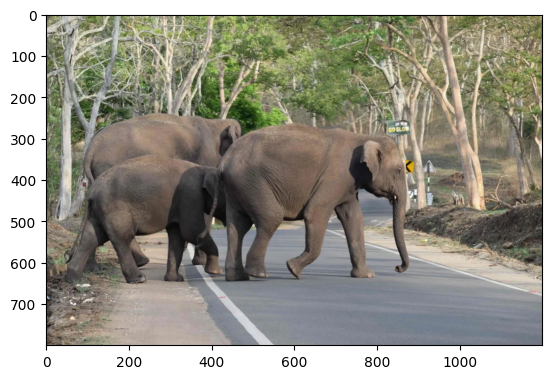

In [91]:
im2 = cv2.imread("/home/mila/v/vaibhav.jade/scratch/intern/ood_distance/notebooks/elephant_road.jpg")
plt.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

In [10]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import cv2
from detectron2.data.datasets import register_coco_instances

In [26]:
predictor = DefaultPredictor(cfg)

In [12]:
!pwd

/network/scratch/v/vaibhav.jade/intern/ood_distance/notebooks


In [104]:
outputs

{'instances': Instances(num_instances=0, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}

In [116]:
instances

Instances(num_instances=35, image_height=800, image_width=1200, fields=[proposal_boxes: Boxes(tensor([[1173.7622,    0.0000, 1200.0000,  800.0000],
        [   0.0000,    0.0000, 1200.0000,  800.0000],
        [ 412.4819,    0.0000, 1200.0000,  800.0000],
        [   0.0000,    0.0000, 1200.0000,  193.1931],
        [1111.1284,    0.0000, 1200.0000,  800.0000],
        [   0.0000,  109.0467, 1200.0000,  109.0467],
        [   0.0000,  435.7791, 1200.0000,  800.0000],
        [ 688.6875,  287.3311, 1200.0000,  800.0000],
        [   0.0000,  262.8975, 1200.0000,  800.0000],
        [ 782.3130,   20.5712, 1200.0000,  152.5811],
        [ 734.0840,    0.0000, 1200.0000,  800.0000],
        [   0.0000,  744.2257, 1200.0000,  745.5021],
        [   0.0000,  611.7854, 1200.0000,  800.0000],
        [1056.0767,    0.0000, 1200.0000,  800.0000],
        [   0.0000,  353.6491, 1200.0000,  353.6492],
        [   0.0000,  562.7039, 1200.0000,  565.0578],
        [   0.0000,  387.5075, 1200.0000, 

In [116]:
from detectron2.structures import Instances

In [118]:
i = Instances((800,1200))
i.pred_boxes = instances.proposal_boxes
i.pred_classes = instances.objectness_logits
i

Instances(num_instances=100, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([[ 399.2410,  270.4949,  900.1802,  637.6940],
        [  14.4517,  288.4372,  505.4096,  671.3233],
        [ 362.3553,  261.7224,  766.8749,  648.4877],
        [  63.8774,  216.7126,  501.8896,  627.8691],
        [  99.8442,  248.3656,  468.3048,  391.7164],
        [ 139.8256,  277.9023,  557.0288,  669.9119],
        [  20.2720,  191.2536,  451.9694,  714.4336],
        [ 427.8658,  200.6723,  894.2094,  713.5110],
        [  67.3700,  283.6666,  671.6171,  655.1855],
        [ 205.5967,  354.1612,  465.0385,  628.1588],
        [   0.0000,  189.2011,  699.7777,  628.3431],
        [  89.7014,  337.8115,  454.6005,  641.7399],
        [ 160.5684,  275.7224,  776.0099,  648.3822],
        [ 507.7680,  235.4538,  911.8659,  678.1602],
        [ 979.9811,  425.8990, 1014.1181,  463.5679],
        [ 265.4258,  237.2781,  875.2028,  635.5523],
        [ 257.2900,  327.1978,  444.1861,  65

In [132]:
preds

[{'instances': Instances(num_instances=1, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([[367.8589,   0.0000, 389.2585, 800.0000]], device='cuda:0',
         grad_fn=<IndexBackward0>)), scores: tensor([1.], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([2], device='cuda:0')])}]

/home/mila/v/vaibhav.jade/detectron2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


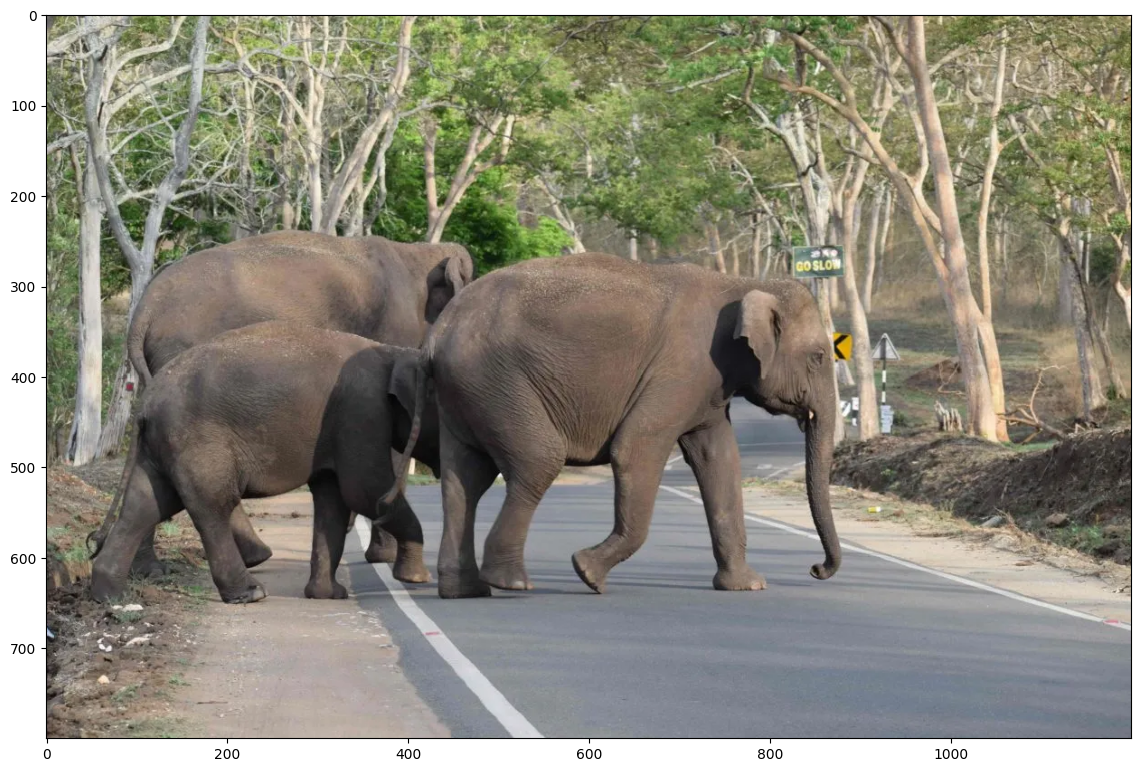

In [125]:
outputs = predictor(im2)
v = Visualizer(im2[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [128]:
model = build_model(cfg)

In [130]:
model.eval()

GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

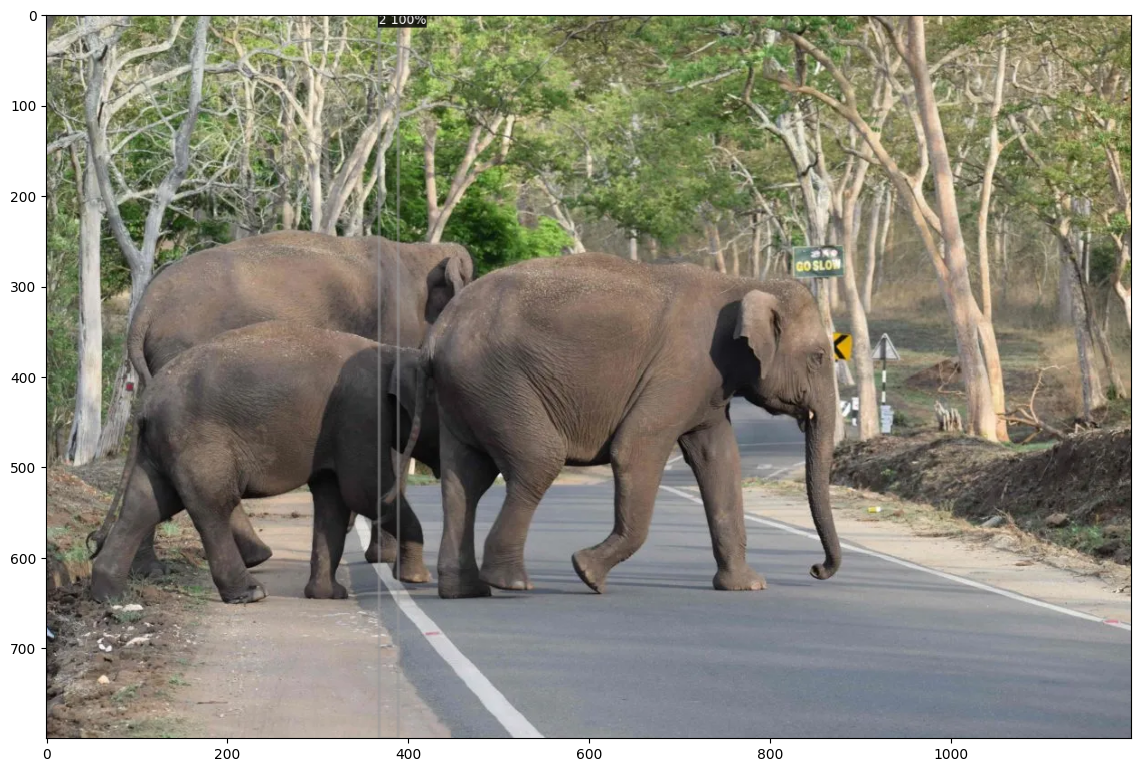

In [133]:
v = Visualizer(image[:, :, ::-1], None)
v = v.draw_instance_predictions(preds[0]["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

In [127]:
[cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST

([800, 800], 1333)

In [126]:
outputs

{'instances': Instances(num_instances=0, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64)])}

In [122]:
predictions

[{'instances': Instances(num_instances=5, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([[   0.0000,    0.0000, 1200.0000,  800.0000],
          [ 566.1140,    0.0000,  567.8182,  800.0000],
          [ 398.7568,  450.0772, 1200.0000,  450.1125],
          [   0.0000,    0.0000, 1200.0000,  800.0000],
          [   0.0000,  220.4644,  999.2461,  235.5756]], device='cuda:0',
         grad_fn=<IndexBackward0>)), scores: tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9998], device='cuda:0',
         grad_fn=<IndexBackward0>), pred_classes: tensor([11,  1,  7,  2,  6], device='cuda:0')])}]

In [123]:
preds

[{'instances': Instances(num_instances=5, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([[   0.0000,    0.0000, 1200.0000,  800.0000],
          [ 566.1140,    0.0000,  567.8182,  800.0000],
          [ 398.7568,  450.0772, 1200.0000,  450.1125],
          [   0.0000,    0.0000, 1200.0000,  800.0000],
          [   0.0000,  220.4644,  999.2461,  235.5756]], device='cuda:0')), scores: tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9998], device='cuda:0'), pred_classes: tensor([11,  1,  7,  2,  6], device='cuda:0')])}]

In [124]:
instances

Instances(num_instances=19, image_height=800, image_width=1200, fields=[proposal_boxes: Boxes(tensor([[   0.0000,    0.0000,  498.8444,  800.0000],
        [   0.0000,  246.7299,  229.9589,  800.0000],
        [   0.0000,  404.5461, 1200.0000,  543.8557],
        [   0.0000,    0.0000,  978.6587,  800.0000],
        [   0.0000,  450.0072,  868.5249,  450.1731],
        [   0.0000,    0.0000, 1200.0000,  122.5474],
        [   0.0000,    0.0000, 1200.0000,  800.0000],
        [   0.0000,    0.0000, 1200.0000,  800.0000],
        [   0.0000,    0.0000, 1200.0000,  237.3979],
        [   0.0000,    0.0000, 1200.0000,   50.6528],
        [   0.0000,    0.0000, 1200.0000,  408.3149],
        [   0.0000,    0.0000,  403.7065,  800.0000],
        [   0.0000,    0.0000, 1200.0000,  466.0010],
        [   0.0000,    0.0000, 1200.0000,   34.8687],
        [   0.0000,    0.0000,  739.7378,  800.0000],
        [   0.0000,    0.0000, 1200.0000,   71.8281],
        [   0.0000,    0.0000,  284.4727, 

In [3]:
def get_Mahalanobis_score(model, copy_model, input, num_classes, sample_mean, precision,magnitude):
    '''
    Compute the proposed Mahalanobis confidence score on input dataset
    return: Mahalanobis score from layer_index
    '''
    
    Mahalanobis = []
    
    inp_image,h,w = input['image'],input['height'],input['width']
    ### the backward graph settings             
    inp_image = inp_image.to(device=device).to(dtype=torch.float32).requires_grad_(True)   

    im = {"image": inp_image, "height": h, "width": w}
    ### forward pass and roi pooling features
    ### Warning! instances here is still connected to graph,
    ### pass it under no_grad() context or be careful    
    instances,out_features = get_features_for_proposals(model,im)
 
    # compute Mahalanobis score
    gaussian_score = 0
    out_features = torch.unsqueeze(out_features,1)
    sample_mean = torch.unsqueeze(sample_mean,0)
    zero_f = out_features - sample_mean     #shape b,n_c,1024
    ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
    gaussian_score = torch.matmul(torch.matmul(zero_f,precision), torch.transpose(zero_f,1,2))
    ### taking diag() of (n_c,n_c) matrices
    gaussian_score = gaussian_score*torch.eye(num_classes,num_classes,device=device)
    gaussian_score = -0.5*gaussian_score.sum(dim=-1)
    
    ### there's no need to calculate again as its the same calculation
    loss = -gaussian_score.max(dim=1)[0]
    
    for l in range(len(loss)):
        if l == len(loss) - 1:
            model.zero_grad()
            inp_image.grad = None
            loss[l].backward()
        else:
            model.zero_grad()
            inp_image.grad = None
            loss[l].backward(retain_graph=True)
        ### sign function on gradients
        gradient =  torch.ge(inp_image.grad, 0)
        gradient = (gradient.float() - 0.5) * 2
    
        ### scaling the gradient by image preprocessing std in original code, 
        ### not needed as its 1 in FasterRCNN, subject to specific case

        # gradient.index_copy_(1, torch.LongTensor([0]).cuda(), gradient.index_select(1, torch.LongTensor([0]).cuda()) / (model.pixel_std[0]))
        # gradient.index_copy_(1, torch.LongTensor([1]).cuda(), gradient.index_select(1, torch.LongTensor([1]).cuda()) / (model.pixel_std[1]))
        # gradient.index_copy_(1, torch.LongTensor([2]).cuda(), gradient.index_select(1, torch.LongTensor([2]).cuda()) / (model.pixel_std[2]))
    
        tempInputs = torch.add(inp_image, -magnitude, gradient)

        with torch.no_grad():
            
            _,noise_out_features = get_features(copy_model,{"image": tempInputs, "height": h, "width": w},instances)

            noise_gaussian_score = 0
            noise_out_features = torch.unsqueeze(noise_out_features[l],0)
            noise_zero_f = noise_out_features - sample_mean.squeeze()     #shape b,n_c,1024
            ### (b,n_c,1024) x (1024,1024) x (b,1024,n_c)= (b,n_c,n_c)
            noise_gaussian_score = -0.5*torch.mm(torch.mm(noise_zero_f,precision), noise_zero_f.t()).diag()
            
            noise_gaussian_score = torch.max(noise_gaussian_score)
            Mahalanobis.append(noise_gaussian_score.cpu().numpy())
        
    return [[instances.pred_boxes.tensor.detach().cpu().numpy(),instances.pred_classes.detach().cpu().numpy()],Mahalanobis]


In [134]:
preds

[{'instances': Instances(num_instances=1, image_height=800, image_width=1200, fields=[pred_boxes: Boxes(tensor([[367.8589,   0.0000, 389.2585, 800.0000]], device='cuda:0',
         grad_fn=<IndexBackward0>)), scores: tensor([1.], device='cuda:0', grad_fn=<IndexBackward0>), pred_classes: tensor([2], device='cuda:0')])}]